# Need for Jacobian adjustment in parameter transformation

In this example, we show sampling under parameter transformation with and without Jacobian adjustment.

In [1]:
import pints
import numpy as np
import matplotlib.pyplot as plt

We create a beta distribution:

$$f(x; a, b) = \frac{\Gamma(a+b)}{\Gamma(a)\Gamma(b)} x^{a-1} (1-x)^{b-1},$$

with $a=2$ and $b=2$.

In [2]:
from scipy.stats import beta

class BetaLogPDF(pints.LogPDF):
    def n_parameters(self):
        return 1

    def __call__(self, x):
        if 0. < x[0] < 1.:
            return np.log(beta.pdf(x, a=2, b=2))[0]
        else:
            return -np.inf

log_pdf = BetaLogPDF()

# Generate some initial positions
x0 = np.random.uniform([0], [1], size=(4, 1))

We try to sample it with MCMC.

In [3]:
# Create an adaptive covariance MCMC routine
mcmc = pints.MCMCController(log_pdf, 4, x0, method=pints.HaarioBardenetACMC)

# Set maximum number of iterations
mcmc.set_max_iterations(10000)

# Disable logging
mcmc.set_log_to_screen(False)

# Number of chains
num_chains = 4

# Run!
print('Running...')
chains = mcmc.run()
print('Done!')

# Discard warm-up
chains = [chain[1000:] for chain in chains]

Running...
Done!


Now we inspect the MCMC samples and how it compares to the analytical form of the beta distribution.

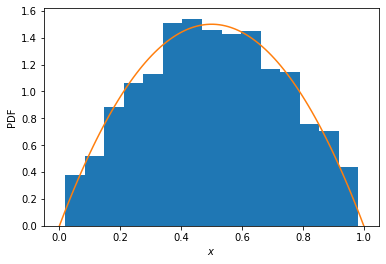

In [4]:
plt.hist(chains[0], bins=15, density=True)
x = np.linspace(0, 1, 100)
plt.plot(x, beta.pdf(x, a=2, b=2))
plt.xlabel(r'$x$')
plt.ylabel('PDF')
plt.show()

So far so good, we are able to sample from the original space $x \in [0, 1]$, let's call this the 'model space' where it's meaningful to be with $0$ and $1$.

Now we consider some transformation, we will use the [logit (or log-odds) transformation](https://pints.readthedocs.io/en/latest/transformations.html#pints.LogitTransformation):

$$y = \text{logit}(x) = \log\left(\frac{x}{1-x}\right),$$

which transforms the constrained model parameter $x$ to an unconstrained search space $y$.

In [5]:
transform = pints.LogitTransformation(1)

We will now compare two transformations of the beta distribution.

The first one is the naive transformation which we simply transform the parameters as if using the [wrapping the model](../optimisation/transformed-parameters-model-wrapper.ipynb) without applying Jacobian adjustment.

In [6]:
class NaiveTransformedLogPDF(pints.LogPDF):
    """Transforming LogPDF without Jacobian adjustment"""
    def __init__(self, log_pdf, transform):
        self._log_pdf = log_pdf
        self._transform = transform
    
    def n_parameters(self):
        return self._log_pdf.n_parameters()
    
    def __call__(self, y):
        # Transform from search space y back to model space x
        x = self._transform.to_model(y)
        # Then we call the log-pdf in the model space x
        return self._log_pdf(x)

naive_trans_log_pdf = NaiveTransformedLogPDF(log_pdf, transform)

# Transform the initial position to search space
y0 = [transform.to_search(x) for x in x0]

We then sample this naive transformed beta distribution using MCMC in the search space $y$.

In [7]:
# Create an adaptive covariance MCMC routine
mcmc = pints.MCMCController(
    naive_trans_log_pdf,  # Naive transformation without Jacobian
    4,
    y0,                   # Input is in the search space y
    method=pints.HaarioBardenetACMC)

# Set maximum number of iterations
mcmc.set_max_iterations(10000)

# Disable logging
mcmc.set_log_to_screen(False)

# Number of chains
num_chains = 4

# Run!
print('Running...')
naive_chains_in_y = mcmc.run()
print('Done!')

# Discard warm-up
naive_chains_in_y = [naive_chain[1000:] for naive_chain in naive_chains_in_y]

Running...
Done!


Let's have a look at what the samples look like in the search space $y$ first.

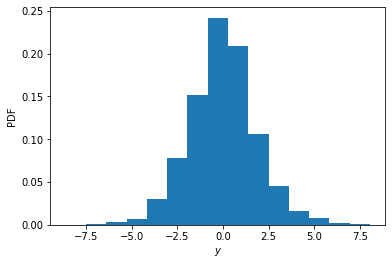

In [8]:
plt.hist(naive_chains_in_y[0], bins=15, density=True)
plt.xlabel(r'$y$')
plt.ylabel('PDF')
plt.show()

OK, not quite sure what that means, $y$ is the search space parameter which we are not interested in it!

Let's backward transform these samples _directly_ back to the model space $x$ and hope for the best...

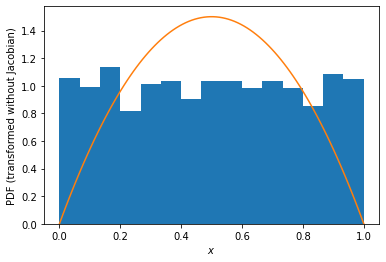

In [9]:
# Transform the samples from y back to x
naive_chains_in_x = transform.multiple_to_model(naive_chains_in_y[0])

plt.hist(naive_chains_in_x, bins=15, density=True)
x = np.linspace(0, 1, 100)
plt.plot(x, beta.pdf(x, a=2, b=2))
plt.xlabel(r'$x$')
plt.ylabel('PDF (transformed without Jacobian)')
plt.show()

The sampled distribution has gone horribly wrong with this naive transformation without Jacobian adjustment!!!

This time we will use [pints.TransformedLogPDF](https://pints.readthedocs.io/en/latest/transformations.html#pints.TransformedLogPDF) which will handle all the necessary correction and adjustment for the transformation!

In [10]:
pints_trans_log_pdf = pints.TransformedLogPDF(log_pdf, transform)

We will repeat the same procedure as before: sampling in the search space $y$.

In [11]:
# Create an adaptive covariance MCMC routine
mcmc = pints.MCMCController(
    pints_trans_log_pdf,  # Transformation using pints
    4,
    y0,                   # Again in search space y
    method=pints.HaarioBardenetACMC)

# Set maximum number of iterations
mcmc.set_max_iterations(10000)

# Disable logging
mcmc.set_log_to_screen(False)

# Number of chains
num_chains = 4

# Run!
print('Running...')
pints_chains_in_y = mcmc.run()
print('Done!')

# Discard warm-up
pints_chains_in_y = [pints_chain[1000:] for pints_chain in pints_chains_in_y]

Running...
Done!


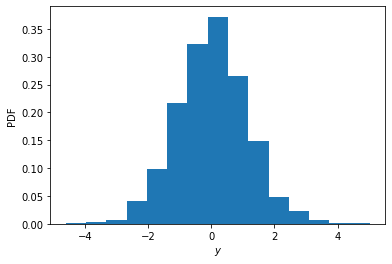

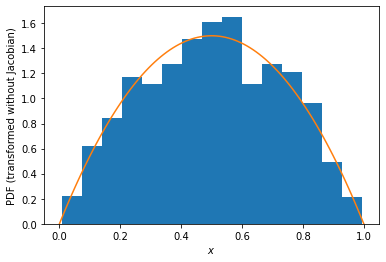

In [12]:
plt.hist(pints_chains_in_y[0], bins=15, density=True)
plt.xlabel(r'$y$')
plt.ylabel('PDF')
plt.show()

# Transform the samples from y back to x
pints_chains_in_x = transform.multiple_to_model(pints_chains_in_y[0])

plt.hist(pints_chains_in_x, bins=15, density=True)
x = np.linspace(0, 1, 100)
plt.plot(x, beta.pdf(x, a=2, b=2))
plt.xlabel(r'$x$')
plt.ylabel('PDF (transformed without Jacobian)')
plt.show()

This is look very much like the correct beta distribution when we using the transform provided by Pints!

This example simply tries to show the importance of the Jacobian adjustment when applying parameter transformation for PDFs! For practical use, all the [pints.Transformation](https://pints.readthedocs.io/en/latest/transformations.html#pints.Transformation) classes can be directly passed to the `Controller`s as shown in [another example notebook](./transformed-parameters.ipynb).